## Instructions

* Before starting the game pleasse read the README.md to understand the game
* To play the game run the notebook and goto the last cell. The rest of the instructions will be there
* There is a little ormatting issue when you run this on Azure platform. So everytime you will give an input you have to scroll  up and see the interface. 

### Libraries

In [8]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from qiskit import *
import getpass
import time, sys

In [9]:
shots = 1024

def build_terrain(n):
    
    #-----------generating states---------#
    Lx = int(2**np.ceil(n/2))
    Ly = int(2**np.floor(n/2))

    strings = {}
    for x in range(Lx):
        for y in range(Ly):
            strings[(x,y)] = ''

    c = 10**n
    num_digits = 0
    while(np.trunc(c/10)>0):
        c = np.trunc(c/10)        
        num_digits += 1

    k = 0    
    for (x,y) in strings:
        binary = ''
        k2 = k
        for i in range(num_digits):
            binary += str( int(k2%2) )
            k2 = np.trunc(k2/2)
        binary = binary[::-1]
        strings[(x,y)] = binary
        k += 1
    #-----------------------------------#
    
    pos = {}
    for y in range(Ly):
        for x in range(Lx):
            pos[strings[(x,y)]] = (x,y)
    
    return strings, pos, Lx, Ly
    
            


In [10]:
def plot_terrain(pos,probs,Lx,Ly,log=True,normalize=True):

    Z = {}
    for node in probs:
        if log:
            Z[node] = np.log(probs[node])
        else:
            Z[node] = probs[node]
        
    minZ = min(Z.values())
    maxZ = max(Z.values())
    colors = {}
    for node in Z:
        if normalize:
            z = (Z[node]-minZ)/(maxZ-minZ)
        else:
            z = Z[node]
        colors[node] = (z,z,z,1)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    tmp = int(np.sqrt(len(probs.keys())))
    for i in range(tmp):
        for j in range(tmp):
            if tmp == 2:
                ax.text(0.5*i+.35,0.5*j+ .20, '|%s>'%'{0:02b}'.format(tmp*j+i),transform=ax.transAxes,fontsize="25", color="gold",horizontalalignment="right", verticalalignment="center")
            if tmp == 4:
                ax.text(0.25*i+.230,0.25*j+ .15, '|%s>'%'{0:04b}'.format(tmp*j+i),transform=ax.transAxes,fontsize="15", color="gold",horizontalalignment="right", verticalalignment="center")
            if tmp == 8:
                ax.text(0.13*i+.096,0.13*j+ .075, '|%s>'%'{0:06b}'.format(tmp*j+i),transform=ax.transAxes,fontsize="6.36", color="gold",horizontalalignment="right", verticalalignment="center")    
    for node in pos:
        rect = matplotlib.patches.Rectangle(pos[node], 1, 1, color=colors[node])
        ax.add_patch(rect)
    plt.xlim([0, Lx])
    plt.ylim([0, Ly])
    plt.axis('off')
    plt.savefig('output.png',dpi=1000)
    plt.show()

In [11]:
def get_probs(job,pos):
    counts = job.result().get_counts()
    probs = {}
    for string in pos:
        try:
            probs[string] = counts[string]/shots
        except:
            probs[string] = 1/shots
    return probs

## Game

In [12]:
def game_level():
    L = 0
    while (L < 1 or L > 3):
        L = int(input('Select game level (1: Easy, 2: Medium, 3: Hard)\n Enter Level: '))
        
        if (L < 1 or L > 3):
            delay_print('Please enter a valid level')
    return L


def get_init_state(L,p):
    qc = QuantumCircuit(2*L)
    init_string = ''
    for i in np.arange(1):
        state_valid = False
        while not state_valid: 
            delay_print("Player %d, select your initial state:" % p)
            delay_print(' 0: |0>\u2297n')
            delay_print(' 1: |1>\u2297n')
            delay_print(' 2: (|0> + |1>)/sqrt(2)\u2297n')
            state = getpass.getpass('')
            print('')
            
            if (state != '0') and (state != '1') and (state != '2'):
                delay_print('Please input a valid state')
            else:
                state_valid=True
                
        init_string += state

    for i, s in enumerate(init_string):
        if s=='1':
            for j in range(2*L):
                qc.x(j)
        if s=='2':
            for j in range(2*L):
                qc.h(j)    
    return qc


def get_gate_and_target(N):
    
    # Get gate to add
    delay_print("  Which gate would you like to add?")
    delay_print("    0:X        (1-qubit)", dt=0.005)
    delay_print("    1:Y        (1-qubit)", dt=0.005)
    delay_print("    2:Z        (1-qubit)", dt=0.005)
    delay_print("    3:H        (1-qubit)", dt=0.005)
    delay_print("    4:Rx(pi/k) (1-qubit)", dt=0.005)
    delay_print("    5:Ry(pi/k) (1-qubit)", dt=0.005)
    delay_print("    6:CNOT     (2-qubit)", dt=0.005)

    while True:
        try:
            gate = int(input('    Input: '))
            k = 0
            if (gate == 4 or gate == 5):
                k = int(input('    Input k: '))
        except ValueError:
            delay_print(    "Sorry, didn't understand that.")
            continue
        else:
            if gate<7:
                break
            if ((gate == 4 or gate == 5) and k <= 0 ):
                print("    Sorry, choose k > 0")
            print("    Sorry, choose a gate between 0 and 6.")

    # Get target(s) to add gate to
    delay_print("  Please specify the qubit position for the gate")
    while True:
        try:
            target = list(map(int, input("    Input (i or i,j): ").split(',')))
            target = [t-1 for t in target]
        except ValueError:
            delay_print(    "Sorry, didn't understand that!")
            continue
        else:

            # Ask for another input if bad qubit index
            if max(target)+1 > N or min(target)+1<1:
                delay_print("    Sorry, use a qubit index between 1 and %d!" % N)
                continue

            # Use this input if we have right number of targets
            if (gate<6 and len(target)==2) or (gate>5 and len(target)==1) or len(target)>2 or len(target)==0:
                delay_print("    Sorry, use the right number of qubits!")
                continue

            break

    return gate, target, k


def game_loop(N_level):
    
    qc = QuantumCircuit(2*N_level)
    qc2 = QuantumCircuit(2*N_level)
    
    if (N_level == 1):
        N_rounds = 2
    elif (N_level == 2):
        N_rounds = 4
    elif (N_level == 3):
        N_rounds = 6
    
    for i in range(N_rounds):

        delay_print("-"*30 + "Round %d!"%(i+1) + "-"*30)

#         for j in range (2*N_level):

#             delay_print("Hello player %d!\n" % (j+1))
        delay_print("Hello player 1" )

        gate, target, k = get_gate_and_target(2*N_level)

        if gate == 0:
            qc.x(target[0])
        elif gate == 1:
            qc.y(target[0])
        elif gate == 2:
            qc.z(target[0])
        elif gate == 3:
            qc.h(target[0])
        elif gate == 4:
            qc.rx(np.pi/k,target[0])
        elif gate == 5:
            qc.ry(np.pi/k,target[0])
        elif gate == 6:
            qc.cx(target[0],target[1])

        print(qc)

        delay_print('\n'+"-"*40)


        delay_print("Hello player 2" )

        gate, target, k = get_gate_and_target(2*N_level)

        if gate == 0:
            qc2.x(target[0])
        elif gate == 1:
            qc2.y(target[0])
        elif gate == 2:
            qc2.z(target[0])
        elif gate == 3:
            qc2.h(target[0])
        elif gate == 4:
            qc2.rx(np.pi/k,target[0])
        elif gate == 5:
            qc2.ry(np.pi/k,target[0])
        elif gate == 6:
            qc2.cx(target[0],target[1])

        print(qc2)

        delay_print('\n'+"-"*40)
        
        
    return qc, qc2

def game_end(N, qc_init, qc_game, qc_init2, qc_game2, pos, probs, Lx, Ly, shots=1024):
    
    backend='qasm_simulator'
    #---------All possible output states---------#
    c = 10**N
    num_digits = 0
    while(np.trunc(c/10)>0):
        c = np.trunc(c/10)        
        num_digits += 1

    k = 0    
    states = []
    for i in range(2**N):
        binary = ''
        k2 = k
        for i in range(num_digits):
            binary += str( int(k2%2) )
            k2 = np.trunc(k2/2)
        binary = binary[::-1]
        states.append(binary)
        k += 1    
    #---------------------------------------------#
    #----------Level 1 game circuit---------------#
    if (N/2 == 1):
        q = QuantumRegister(N)
        qc_ = QuantumCircuit(q)
        qc_.h(q[0])
#         qc_.x(q[1])
        for j in range(N-1):
            qc_.cx(q[j],q[j+1])

        t=random.uniform(0,1)
        qc_.ry(0.65*t*np.pi,0)
        qc_.measure_all()
        backend = Aer.get_backend('qasm_simulator')
        job = backend.run(qc_, shots=shots)
        result = job.result()
        counts = result.get_counts()
    #---------------------------------------------#
    #----------Level 2 game circuit---------------#
    elif (N/2 == 2):
        q = QuantumRegister(N)
        qc_ = QuantumCircuit(q)
        qc_.h(q[0])
        for j in range(N-1):
            qc_.cx(q[j],q[j+1])

        t1=random.uniform(0,1)
        t2=random.uniform(0,0.25)
        t3= random.uniform(0,0.02) 
        qc_.ry(0.65*t1*np.pi,0)
        qc_.ry(0.65*t2*np.pi,2)
#         qc_.ry(0.65*t2*np.pi,3)
        qc_.measure_all()
        backend = Aer.get_backend('qasm_simulator')
        job = backend.run(qc_, shots=shots)
        result = job.result()
        counts = result.get_counts()
    #---------------------------------------------#
    #----------Level 3 game circuit---------------#
    elif (N/2 == 3):
        q = QuantumRegister(N)
        qc_ = QuantumCircuit(q)
        qc_.h(0)
#         for j in range(N-1):
#             qc_.cx(q[j],q[j+1])

        t1=random.uniform(0,1)
        t2=random.uniform(0,0.25)
        t3= random.uniform(0,0.02) 
        qc_.h(q[3])

        qc_.ry(0.65*t1*np.pi,1)
        qc_.rx(0.65*t2*np.pi,3)
        qc_.ry(0.65*t2*np.pi,5)

        for j in range(N-1):
            qc_.cx(q[j+1],q[j])        
        qc_.measure_all()
        backend = Aer.get_backend('qasm_simulator')
        job = backend.run(qc_, shots=shots)
        result = job.result()
        counts = result.get_counts()
    #---------------------------------------------#
    
    qc = qc_init + qc_game
    qc.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(qc, shots=shots)
    result = job.result()
    p1_counts = result.get_counts()
    delay_print(80*'-', dt=0.002)    
    delay_print('Player 1 target map:', dt=0.005)
    probs = get_probs(job,pos)
    plot_terrain(pos,probs,Lx,Ly)

    qc2 = qc_init2 + qc_game2
    qc2.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(qc2, shots=shots)
    result = job.result()
    p2_counts = result.get_counts()
    delay_print(80*'-', dt=0.002)    
    delay_print('Player 2 target map:', dt=0.005)
    probs = get_probs(job,pos)
    plot_terrain(pos,probs,Lx,Ly)
    
    prob_vec0 = np.zeros(2**N)
    prob_vec1 = np.zeros(2**N)
    prob_vec2 = np.zeros(2**N)
    x = 0
    for st in states:
        if st in counts:
            prob_vec0[x] = counts[st]/shots
        if st in p1_counts:
            prob_vec1[x] = p1_counts[st]/shots
        if st in p2_counts:
            prob_vec2[x] = p2_counts[st]/shots
        x += 1
    
    p1_dist = np.linalg.norm(prob_vec0-prob_vec1)
    p2_dist = np.linalg.norm(prob_vec0-prob_vec2)
            
    if (N/2 == 1):
        print("Target states probabilities:", prob_vec0)
        print("Player 1 probabilities:", prob_vec1)
        print("Player 2 probabilities:", prob_vec2)
    print("Ditance from target for Player 1:", p1_dist)
    print("Ditance from target for Player 2:", p2_dist)
    
    winner = ''
    if ( (p1_dist < p2_dist) and (p1_dist <= 0.3) ):
        winner = '1'
    elif ( (p1_dist > p2_dist) and (p2_dist <= 0.3) ):
        winner = '2'
    else:
        winner = 'Both'
    
    return winner


def delay_print(s, dt=0.00):
    for c in s:
        sys.stdout.write(c)
        sys.stdout.flush()
        time.sleep(dt)
    sys.stdout.write('\n')
    sys.stdout.flush()
    
    
def main():
    
    f = open("title.txt", "r", encoding="utf8")
    delay_print(f.read(), dt=0.00000000005)
    delay_print(80*'-', dt=0.00000000005)
    delay_print('In this game, a map will be shown.The given map is nothing but a probability distribution of the basis states', dt=0.005)
    s1 = " The objective in this game is to construct a quantum circuit which provides a best guess to the given map."
    s2 = " There are three different levels, Easy: level 1 (2 qubits, 2 Gates at max), Medium: level 2 (4 qubits, 4 Gates at max) and Hard: level 3 (6 qubits, 6 Gates at max)."
    s3 = " Players will select an initial wavefunction and create a quantum circuit by adding different gates at each step"
    s6 = " At the end of every step the quantum circuit will be printed for participants visualization"
    s4 = " Finally the circuit will be evaluated and the participant's results will be compared with the original map"
    s5 = " The closest guess will win!"
    delay_print(s1+s2+s3+s6+s4+s5, dt=0.05)

#     N = get_players()
    N = 2
    delay_print(80*'-', dt=0.002)
    L = game_level()
    strings, pos, Lx, Ly = build_terrain(2*L)
    #----------Level 1 game circuit---------------#
    if (L == 1):
        delay_print(80*'-', dt=0.002)    
        delay_print('Level 1 target map:', dt=0.005)
        q = QuantumRegister(2*L) 
        qc_ = QuantumCircuit(q)
        qc_.h(q[0])
#         qc_.x(1)
        for j in range(2*L-1):
            qc_.cx(q[j],q[j+1])

        t=random.uniform(0,1)
        qc_.ry(0.65*t*np.pi,0)
        qc_.measure_all()
        backend = Aer.get_backend('qasm_simulator')
        job = backend.run(qc_, shots=shots)
        probs = get_probs(job,pos)
        plot_terrain(pos,probs,Lx,Ly)
    #---------------------------------------------#
    #----------Level 2 game circuit---------------#
    elif (L == 2):
        delay_print(80*'-', dt=0.002)    
        delay_print('Level 2 target map:', dt=0.005)
        q = QuantumRegister(2*L)
        qc_ = QuantumCircuit(q)
        qc_.h(q[0])
        for j in range(2**L-1):
            qc_.cx(q[j],q[j+1])

        t1=random.uniform(0,1)
        t2=random.uniform(0,0.25)
        t3= random.uniform(0,0.02) 
        qc_.ry(0.65*t1*np.pi,q[0])
        qc_.ry(0.65*t2*np.pi,q[2])
#         qc_.ry(0.65*t3*np.pi,q[3])
        qc_.measure_all()
        backend = Aer.get_backend('qasm_simulator')
        job = backend.run(qc_, shots=shots)
        probs = get_probs(job,pos)
        plot_terrain(pos,probs,Lx,Ly)
    #---------------------------------------------#
    #----------Level 3 game circuit---------------#
    elif (L == 3):
        delay_print(80*'-', dt=0.002)    
        delay_print('Level 3 target map:', dt=0.005)
        q = QuantumRegister(2*L)
        qc_ = QuantumCircuit(q)
        qc_.h(0)
#         for j in range(2**L-1):
#             qc_.cx(q[j],q[j+1])

        t1=random.uniform(0,1)
        t2=random.uniform(0,0.25)
        t3= random.uniform(0,0.02) 
        qc_.h(q[3])

        qc_.ry(0.65*t1*np.pi,1)
        qc_.rx(0.65*t2*np.pi,3)
        qc_.ry(0.65*t2*np.pi,5)
        
        qc_.measure_all()
        backend = Aer.get_backend('qasm_simulator')
        job = backend.run(qc_, shots=shots)
        probs = get_probs(job,pos)
#         print(pos,probs)
        plot_terrain(pos,probs,Lx,Ly)

    #---------------------------------------------#
    
    delay_print(80*'-', dt=0.002)    
    delay_print('Let the game begin! The players should secretly select their initial state:', dt=0.005)
    qc_init1 = get_init_state(L,1)
    qc_init2 = get_init_state(L,2)
    delay_print(80*'-', dt=0.002)
    delay_print('It is time to build your quantum circuit by making the best choice of gates:', dt=0.005)
    qc_game1, qc_game2 = game_loop(L)
    
    delay_print('Measuring...', dt=0.002)
    winner = game_end(2*L, qc_init1, qc_game1, qc_init2, qc_game2, pos, probs, Lx,Ly)
        
    delay_print('Final Circuit:')
    print(qc_init1 + qc_game1)
    print(qc_init2 + qc_game2)
    delay_print('')
    
    delay_print('Results:')
    if (winner == 'Both'):
        print("Oops! None of you could HACK the QMap!")
    else:
        print("Congratulations!")
        delay_print('Player ' + winner + ' is the winner. Congratulations. You have HACKED the QMAP! \N{PARTY POPPER}')


﻿
█░█ ▄▀█ █▀▀ █▄▀   ▀█▀ █░█ █▀▀   █▀█ ▄▄ █▀▄▀█ ▄▀█ █▀█
█▀█ █▀█ █▄▄ █░█   ░█░ █▀█ ██▄   ▀▀█ ░░ █░▀░█ █▀█ █▀▀
--------------------------------------------------------------------------------
In this game, a map will be shown.The given map is nothing but a probability distribution of the basis states
 The objective in this game is to construct a quantum circuit which provides a best guess to the given map. There are three different levels, Easy: level 1 (2 qubits, 2 Gates at max), Medium: level 2 (4 qubits, 4 Gates at max) and Hard: level 3 (6 qubits, 6 Gates at max). Players will select an initial wavefunction and create a quantum circuit by adding different gates at each step At the end of every step the quantum circuit will be printed for participants visualization Finally the circuit will be evaluated and the participant's results will be compared with the original map The closest guess will win!
--------------------------------------------------------------------------------
Select g

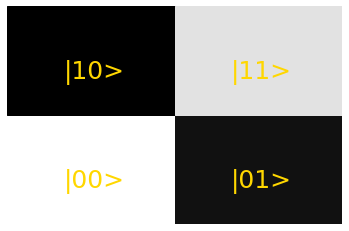

--------------------------------------------------------------------------------
Let the game begin! The players should secretly select their initial state:
Player 1, select your initial state:
 0: |0>⊗n
 1: |1>⊗n
 2: (|0> + |1>)/sqrt(2)⊗n
········

Player 2, select your initial state:
 0: |0>⊗n
 1: |1>⊗n
 2: (|0> + |1>)/sqrt(2)⊗n
········

--------------------------------------------------------------------------------
It is time to build your quantum circuit by making the best choice of gates:
------------------------------Round 1!------------------------------
Hello player 1
  Which gate would you like to add?
    0:X        (1-qubit)
    1:Y        (1-qubit)
    2:Z        (1-qubit)
    3:H        (1-qubit)
    4:Rx(pi/k) (1-qubit)
    5:Ry(pi/k) (1-qubit)
    6:CNOT     (2-qubit)
    Input: 3
  Please specify the qubit position for the gate
    Input (i or i,j): 1
     ┌───┐
q_0: ┤ H ├
     └───┘
q_1: ─────
          

----------------------------------------
Hello player 2
  Whic

C:\Users\sumit\AppData\Local\Temp/ipykernel_28420/3028313306.py:249: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  qc = qc_init + qc_game
C:\Users\sumit\miniconda3\envs\ibmqiskit\lib\site-packages\qiskit\circuit\quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


-------------------------------------------------------------------
Player 1 target map:


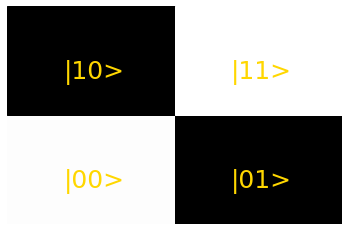

--------------------------------------------------------------------------------
Player 2 target map:


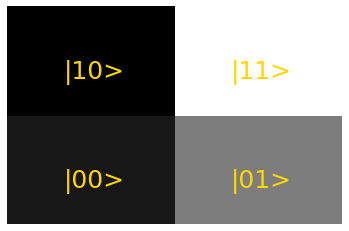

Target states probabilities: [0.50292969 0.         0.         0.49707031]
Player 1 probabilities: [0.48730469 0.         0.         0.51269531]
Player 2 probabilities: [0.24316406 0.24121094 0.25195312 0.26367188]
Ditance from target for Player 1: 0.02209708691207961
Ditance from target for Player 2: 0.4935748212034084
Final Circuit:
     ┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
     ┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤ Y ├
     ├───┤└───┘└───┘
q_1: ┤ H ├──────────
     └───┘          

Results:
Congratulations!
Player 1 is the winner. Congratulations. You have HACKED the QMAP! 🎉


In [13]:
main()